In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.stats import entropy
import ruptures as rpt
import seaborn as sns  
from sklearn.linear_model import LinearRegression

In [ ]:

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving monitoramento-memoria-baixa-carga-sqlserver.txt to monitoramento-memoria-baixa-carga-sqlserver.txt
User uploaded file "monitoramento-memoria-baixa-carga-sqlserver.txt" with length 2010919 bytes


In [ ]:
arquivo = list(uploaded.keys())[0]

df = pd.read_csv(arquivo, delim_whitespace=True)
df.head()

/tmp/ipython-input-38-621391523.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(arquivo, delim_whitespace=True)


,Mem_used,Mem_free,Mem_total,Mem_Disp,Date,Time,Elapsed_time
0,1362348,3387380,7088316,5479624,2022-12-22,14:37:13,0
1,1371252,3378308,7088316,5470700,2022-12-22,14:37:18,5
2,1371752,3377804,7088316,5470220,2022-12-22,14:37:23,10
3,1371740,3377804,7088316,5470232,2022-12-22,14:37:28,15
4,1372232,3377300,7088316,5469740,2022-12-22,14:37:33,20


In [ ]:
# === DECOMPOSição STL ===
print("Iniciando decomposição STL...")
periodo_sazonal = 1440
coluna_alvo = 'Mem_used' # Defining coluna_alvo
serie_limpa = df[coluna_alvo].dropna()
stl = STL(serie_limpa, period=periodo_sazonal)
resultado_stl = stl.fit()
df['trend'] = resultado_stl.trend
df['seasonal'] = resultado_stl.seasonal
df['residual'] = resultado_stl.resid
print("STL concluído.")

Iniciando decomposição STL...
STL concluído.


In [ ]:
def remover_warmup(df_original, tempo_corte_segundos=600):
    print(f"Formato original do dataset: {df_original.shape[0]} linhas")

    df_warmup = df_original[df_original['Elapsed_time'] < tempo_corte_segundos].copy()
    df_principal = df_original[df_original['Elapsed_time'] >= tempo_corte_segundos].copy()
    df_principal.reset_index(drop=True, inplace=True)

    print(f"Dados removidos (warm-up): {df_warmup.shape[0]} linhas")
    print(f"Novo formato do dataset principal: {df_principal.shape[0]} linhas")

    return df_principal, df_warmup

df, df_warmup_isolado = remover_warmup(df, tempo_corte_segundos=600)

print("\n--- Processo de remoção da fase de warm-up concluído. ---")
print("O DataFrame 'df' agora contém apenas os dados a partir de 600 segundos.")

Formato original do dataset: 34459 linhas
Dados removidos (warm-up): 120 linhas
Novo formato do dataset principal: 34339 linhas

--- Processo de remoção da fase de warm-up concluído. ---
O DataFrame 'df' agora contém apenas os dados a partir de 600 segundos.


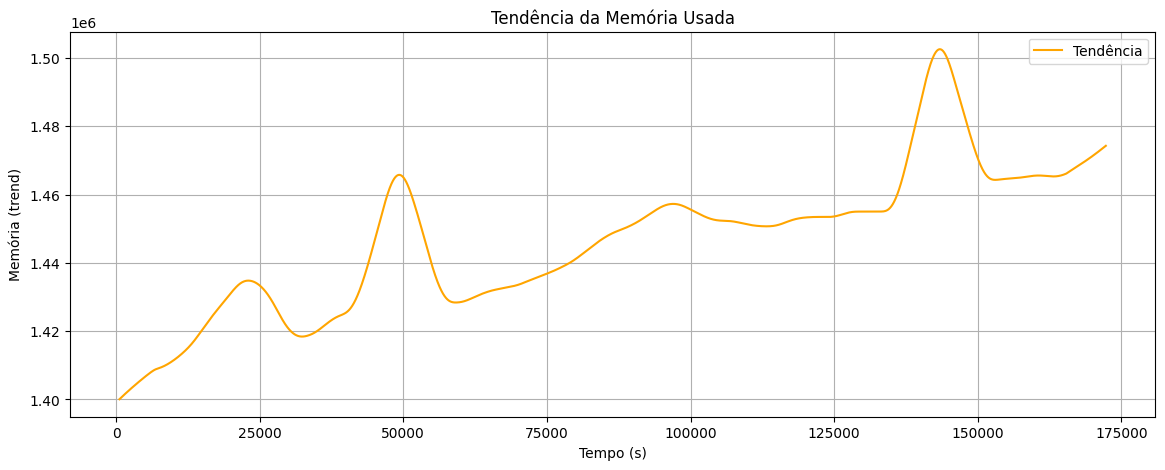

In [ ]:
# === VISUALIZAÇÃO DA TENDÊNCIA ===
plt.figure(figsize=(14, 5))
plt.plot(df['Elapsed_time'], df['trend'], label='Tendência', color='orange')
plt.title('Tendência da Memória Usada')
plt.xlabel('Tempo (s)')
plt.ylabel('Memória (trend)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
janela = 720 
passo = 360 
labels = np.zeros(len(df))
trend = df['trend'].values

for i in range(0, len(trend) - janela, passo):
    y = trend[i:i+janela].reshape(-1, 1)
    x = np.arange(janela).reshape(-1, 1)
    modelo = LinearRegression().fit(x, y)
    inclinacao = modelo.coef_[0][0]

    if inclinacao > 0.5:
        labels[i:i+janela] = 1

df['Aging_Label'] = labels

In [ ]:
df

,Mem_used,Mem_free,Mem_total,Mem_Disp,Date,Time,Elapsed_time,trend,seasonal,residual,Aging_Label
0,1362348,3387380,7088316,5479624,2022-12-22,14:37:13,0,1.399079e+06,-17500.039050,-19231.177504,1.0
1,1371252,3378308,7088316,5470700,2022-12-22,14:37:18,5,1.399088e+06,-11672.538874,-16163.137350,1.0
2,1371752,3377804,7088316,5470220,2022-12-22,14:37:23,10,1.399096e+06,-11164.675521,-16179.458029,1.0
3,1371740,3377804,7088316,5470232,2022-12-22,14:37:28,15,1.399105e+06,-11327.143584,-16037.444948,1.0
4,1372232,3377300,7088316,5469740,2022-12-22,14:37:33,20,1.399113e+06,-10595.718927,-16285.322242,1.0
...,...,...,...,...,...,...,...,...,...,...,...
34454,1494724,2709700,7088316,5344512,2022-12-24,14:47:47,172270,1.474250e+06,17843.734056,2629.816001,0.0
34455,1493956,2710456,7088316,5345280,2022-12-24,14:47:52,172275,1.474257e+06,17493.947908,2204.883300,0.0
34456,1493940,2710460,7088316,5345296,2022-12-24,14:47:57,172280,1.474264e+06,18024.237168,1651.874297,0.0
34457,1493924,2710460,7088316,5345312,2022-12-24,14:48:02,172285,1.474271e+06,18374.389850,1279.000978,0.0


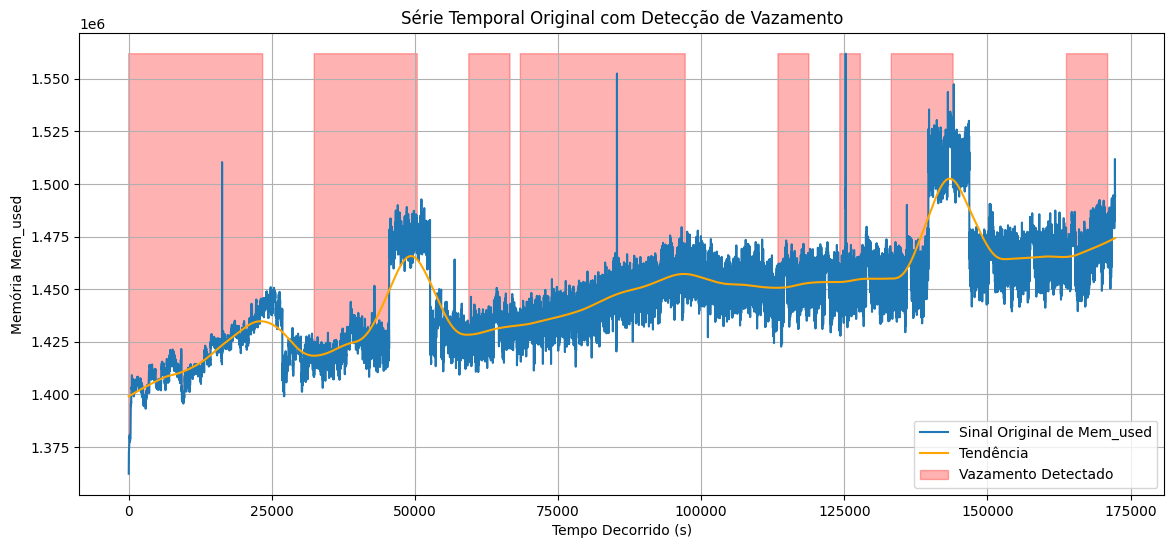

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Elapsed_time'], df[coluna_alvo], label=f'Sinal Original de {coluna_alvo}')
plt.plot(df['Elapsed_time'], df['trend'], label='Tendência', color='orange')
plt.fill_between(df['Elapsed_time'], df[coluna_alvo], df[coluna_alvo].max(), where=df['Aging_Label'] == 1, color='red', alpha=0.3, label='Vazamento Detectado')
plt.title('Série Temporal Original com Detecção de Vazamento')
plt.xlabel('Tempo Decorrido (s)')
plt.ylabel(f'Memória {coluna_alvo}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df

,Mem_used,Mem_free,Mem_total,Mem_Disp,Date,Time,Elapsed_time,trend,seasonal,residual,Aging_Label
0,1402820,3344132,7088316,5439124,2022-12-22,14:47:17,600,1.400077e+06,6235.816481,-3493.248468,1.0
1,1403712,3343228,7088316,5438236,2022-12-22,14:47:22,605,1.400086e+06,6884.818306,-3258.426007,1.0
2,1403308,3343616,7088316,5438640,2022-12-22,14:47:27,610,1.400094e+06,6811.470260,-3597.251361,1.0
3,1403320,3343592,7088316,5438628,2022-12-22,14:47:32,615,1.400102e+06,6480.655797,-3262.607988,1.0
4,1403892,3343012,7088316,5438056,2022-12-22,14:47:37,620,1.400110e+06,6527.747563,-2745.868534,1.0
...,...,...,...,...,...,...,...,...,...,...,...
34334,1494724,2709700,7088316,5344512,2022-12-24,14:47:47,172270,1.474250e+06,17843.734056,2629.816001,0.0
34335,1493956,2710456,7088316,5345280,2022-12-24,14:47:52,172275,1.474257e+06,17493.947908,2204.883300,0.0
34336,1493940,2710460,7088316,5345296,2022-12-24,14:47:57,172280,1.474264e+06,18024.237168,1651.874297,0.0
34337,1493924,2710460,7088316,5345312,2022-12-24,14:48:02,172285,1.474271e+06,18374.389850,1279.000978,0.0


In [ ]:
colunas_finais = df.columns
df_warmup_ajustado = df_warmup_isolado.reindex(columns=colunas_finais, fill_value=pd.NA) 
df_warmup_ajustado['Aging_Label'] = 0

df = pd.concat([df_warmup_ajustado, df], ignore_index=True)

df = df.sort_values(by='Elapsed_time')

print("DataFrame final unificado, limpo e ordenado:")
display(df.head(10))

print("\nValores de 'Aging_Label' no DataFrame final:")
print(df['Aging_Label'].unique())

DataFrame final unificado, limpo e ordenado:


,Mem_used,Mem_free,Mem_total,Mem_Disp,Date,Time,Elapsed_time,trend,seasonal,residual,Aging_Label
0,1362348,3387380,7088316,5479624,2022-12-22,14:37:13,0,1.399079e+06,-17500.039050,-19231.177504,0.0
1,1371252,3378308,7088316,5470700,2022-12-22,14:37:18,5,1.399088e+06,-11672.538874,-16163.137350,0.0
2,1371752,3377804,7088316,5470220,2022-12-22,14:37:23,10,1.399096e+06,-11164.675521,-16179.458029,0.0
3,1371740,3377804,7088316,5470232,2022-12-22,14:37:28,15,1.399105e+06,-11327.143584,-16037.444948,0.0
4,1372232,3377300,7088316,5469740,2022-12-22,14:37:33,20,1.399113e+06,-10595.718927,-16285.322242,0.0
5,1372468,3377048,7088316,5469504,2022-12-22,14:37:38,25,1.399121e+06,-10414.171289,-16239.320168,0.0
6,1372708,3376796,7088316,5469264,2022-12-22,14:37:43,30,1.399130e+06,-10522.431251,-15899.508143,0.0
7,1372680,3376796,7088316,5469284,2022-12-22,14:37:48,35,1.399138e+06,-10814.429689,-15643.955290,0.0
8,1372916,3376544,7088316,5469052,2022-12-22,14:37:53,40,1.399147e+06,-10916.450282,-15314.377928,0.0
9,1372908,3376544,7088316,5469060,2022-12-22,14:37:58,45,1.399155e+06,-11130.834133,-15116.434952,0.0



Valores de 'Aging_Label' no DataFrame final:
[0. 1.]


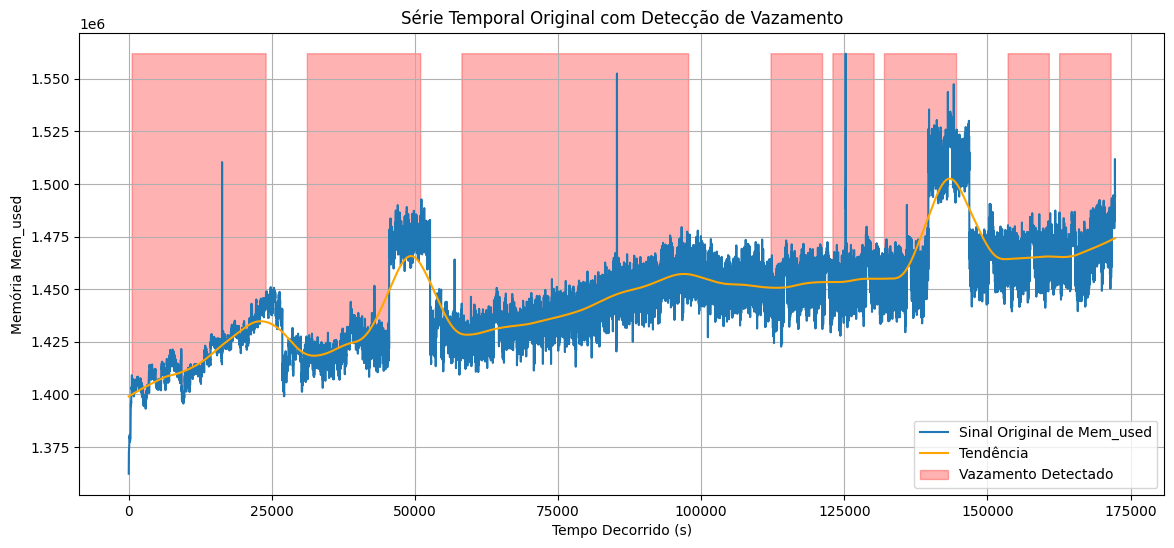

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Elapsed_time'], df[coluna_alvo], label=f'Sinal Original de {coluna_alvo}')
plt.plot(df['Elapsed_time'], df['trend'], label='Tendência', color='orange')
plt.fill_between(df['Elapsed_time'], df[coluna_alvo], df[coluna_alvo].max(), where=df['Aging_Label'] == 1, color='red', alpha=0.3, label='Vazamento Detectado')
plt.title('Série Temporal Original com Detecção de Vazamento')
plt.xlabel('Tempo Decorrido (s)')
plt.ylabel(f'Memória {coluna_alvo}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("\n--- A gerar a Análise de Correlação ---")
corr_table = df.corr(numeric_only=True)
print("Tabela de correlação:")
print(corr_table)


--- A gerar a Análise de Correlação ---
Tabela de correlação:
              Mem_used  Mem_free  Mem_total  Mem_Disp  Elapsed_time     trend  \
Mem_used      1.000000 -0.805081        NaN -0.995588      0.748420  0.918136   
Mem_free     -0.805081  1.000000        NaN  0.841186     -0.984444 -0.892942   
Mem_total          NaN       NaN        NaN       NaN           NaN       NaN   
Mem_Disp     -0.995588  0.841186        NaN  1.000000     -0.787721 -0.927959   
Elapsed_time  0.748420 -0.984444        NaN -0.787721      1.000000  0.861126   
trend         0.918136 -0.892942        NaN -0.927959      0.861126  1.000000   
seasonal      0.233627 -0.044215        NaN -0.218494      0.016063  0.012814   
residual      0.470530 -0.062287        NaN -0.440558     -0.008329  0.141147   
Aging_Label  -0.132788  0.129357        NaN  0.126112     -0.127742 -0.169747   

              seasonal  residual  Aging_Label  
Mem_used      0.233627  0.470530    -0.132788  
Mem_free     -0.044215 -0.0622

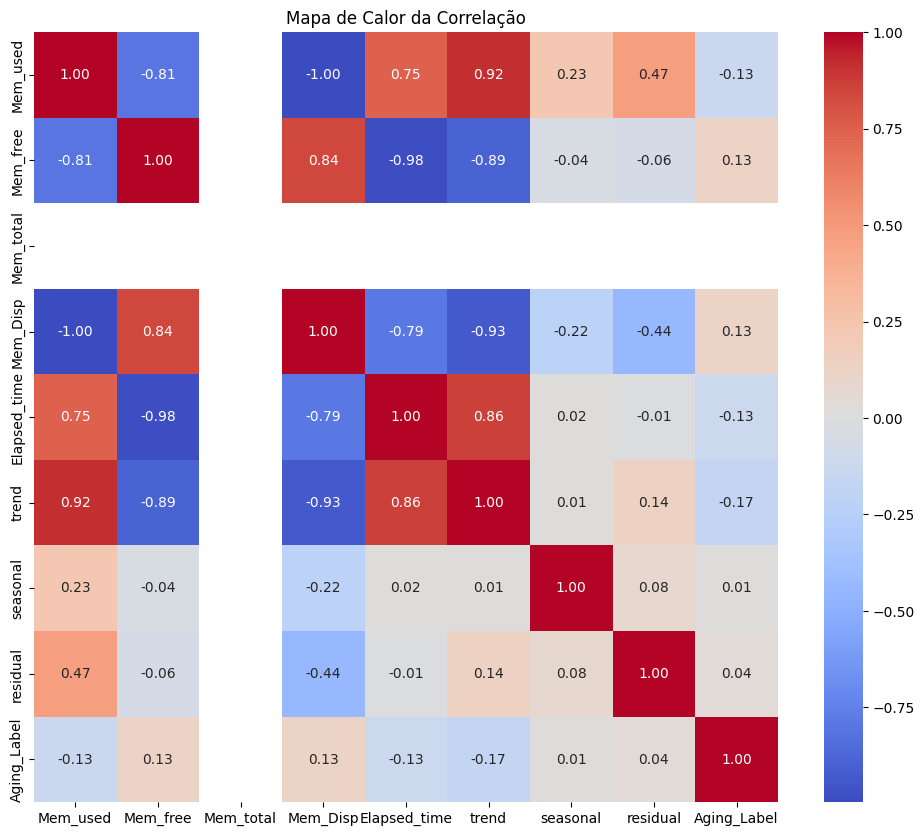

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor da Correlação')
plt.show()

In [ ]:
print(df['Aging_Label'].value_counts(normalize=True))

Aging_Label
1.0    0.741751
0.0    0.258249
Name: proportion, dtype: float64


In [ ]:
base_filename = arquivo.rsplit('.', 1)[0]
csv_filename = f'{base_filename}.csv'
df.to_csv(csv_filename, index=False)
files.download(csv_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>